## Identifying planes in images

Single-Image Piece-wise Planar 3D Reconstruction via Associative Embedding  
https://arxiv.org/pdf/1902.09777.pdf  
https://github.com/svip-lab/PlanarReconstruction

---

#### Related sources:

---

PlaneRCNN: 3D Plane Detection and Reconstruction from a Single Image  
https://arxiv.org/pdf/1812.04072.pdf  
https://github.com/NVlabs/planercnn  
  
Requires PyTorch 0.4.1 and Cuda 9 (we have Cuda 11, so we cannot use)   

---

Recovering 3D Planes from a Single Image via Convolutional Neural Networks  
https://faculty.ist.psu.edu/zzhou/paper/ECCV18-plane.pdf  
https://github.com/fuy34/planerecover  

---

PlaneNet: Piece-wise Planar Reconstruction from a Single RGB Image  
http://art-programmer.github.io/planenet/paper.pdf  
https://github.com/art-programmer/PlaneNet

In [1]:
%config InlineBackend.figure_format = 'retina'

from IPython.display import display

import os
from os import path
import time
from datetime import timedelta
import math
import random

import cv2
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from scipy.spatial import distance as dist
from PIL import Image
import pytesseract
from matplotlib import pyplot as plt
import matplotlib as mpl

from sacred import Experiment
from easydict import EasyDict as edict

# from skimage import morphology
# from skimage.measure import label

import torch
import torch.nn.functional as F
import torchvision.transforms as tf

from fastai.vision.all import *

from planar.models.baseline_same import Baseline as UNet
from planar.utils.disp import tensor_to_image
from planar.utils.disp import colors_256 as colors
from planar.bin_mean_shift import Bin_Mean_Shift
from planar.modules import get_coordinate_map
from planar.utils.loss import Q_loss
from planar.instance_parameter_loss import InstanceParameterLoss

ex = Experiment('jupyter', interactive=True)


In [2]:
# ray casting

def get_K_inv_dot_xy_1(h=192, w=256):
    focal_length = 517.97
    offset_x = 320
    offset_y = 240

    K = [[focal_length, 0, offset_x],
         [0, focal_length, offset_y],
         [0, 0, 1]]

    K_inv = np.linalg.inv(np.array(K))

    K_inv_dot_xy_1 = np.zeros((3, h, w))

    for y in range(h):
        for x in range(w):
            yy = float(y) / h * 480
            xx = float(x) / w * 640
                
            ray = np.dot(K_inv,
                         np.array([xx, yy, 1]).reshape(3, 1))
            K_inv_dot_xy_1[:, y, x] = ray[:, 0]

    return K_inv_dot_xy_1


K_inv_dot_xy_1 = get_K_inv_dot_xy_1()

# for troubleshooting -- may not need in the future
# PLY files can be opened in meshlab

def writePLYFileDepth(folder, index, depth, segmentation, segment_to_use):
    h, w = 192, 256
    imageFilename = str(index) + '_segmentation_pred_blended_0.png'

    # create face from segmentation
    faces = []
    for y in range(h - 1):
        for x in range(w - 1):
            segmentIndex = segmentation[y, x]
            # ignore non planar region
            if segmentIndex == 0:
                continue

            if segment_to_use != 0 and segmentIndex != segment_to_use:
                continue
                
            # add face if three pixels have the same segmentation
            depths = [depth[y][x], depth[y + 1][x], depth[y + 1][x + 1]]
            if segmentation[y + 1, x] == segmentIndex and segmentation[y + 1, x + 1] == segmentIndex and min(depths) > 0 and max(depths) < 10:
                faces.append((x, y, x, y + 1, x + 1, y + 1))

            depths = [depth[y][x], depth[y][x + 1], depth[y + 1][x + 1]]
            if segmentation[y][x + 1] == segmentIndex and segmentation[y + 1][x + 1] == segmentIndex and min(depths) > 0 and max(depths) < 10:
                faces.append((x, y, x + 1, y + 1, x + 1, y))

    with open(folder + '/' + str(index) + '_model.ply', 'w') as f:
        header = """ply
format ascii 1.0
comment VCGLIB generated
comment TextureFile """
        header += imageFilename
        header += """
element vertex """
        header += str(h * w)
        header += """
property float x
property float y
property float z
element face """
        header += str(len(faces))
        header += """
property list uchar int vertex_indices
property list uchar float texcoord
end_header
"""
        f.write(header)
        for y in range(h):
            for x in range(w):
                segmentIndex = segmentation[y][x]
                if segmentIndex == 20:
                    f.write("0.0 0.0 0.0\n")
                    continue
                ray = K_inv_dot_xy_1[:, y, x]
                X, Y, Z = ray * depth[y, x]
                f.write(str(X) + ' ' +    str(Y) + ' ' + str(Z) + '\n')

        for face in faces:
            f.write('3 ')
            for c in range(3):
                f.write(str(face[c * 2 + 1] * w + face[c * 2]) + ' ')
            f.write('6 ')
            for c in range(3):
                f.write(str(float(face[c * 2]) / w) + ' ' + str(1 - float(face[c * 2 + 1]) / h) + ' ')
            f.write('\n')
        f.close()
        
    return

In [3]:
def getPointsForSegment(segmentation, segment_to_use):
    h, w = 192, 256

    points = []
    
    for y in range(h):
        for x in range(w):
            segmentIndex = segmentation[y][x]

            if segmentIndex != segment_to_use:
                continue

            points.append(np.array([float(x), float(y)]))
            
    return points

In [4]:
# matrix and vector utilities

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def deg_to_rad(deg):
    return deg * pi / 180.0

def rad_to_deg(rad):
    return deg * 180.0 / pi

In [5]:
def predict(cfg):
    # build network
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    network = UNet(cfg.model)

    if not (cfg.resume_dir == 'None'):
        model_dict = torch.load(cfg.resume_dir, map_location=lambda storage, loc: storage)
        network.load_state_dict(model_dict)

    # load into gpu
    if cfg.num_gpus > 1 and torch.cuda.is_available():
        network = torch.nn.DataParallel(network)
    network.to(device)
    network.eval()

    transforms = tf.Compose([
        tf.ToTensor(),
        tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    bin_mean_shift = Bin_Mean_Shift(device=device)
    k_inv_dot_xy1 = get_coordinate_map(device)
    instance_parameter_loss = InstanceParameterLoss(k_inv_dot_xy1)

    # the network is trained with 192*256 and the intrinsic parameter is set as ScanNet
    h, w = 192, 256

    with torch.no_grad():
        image = cv2.imread(cfg.image_path)
        image = cv2.resize(image, (w, h))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = transforms(image)
        image = image.to(device).unsqueeze(0)
        
        # forward pass
        logit, embedding, _, _, param = network(image)

        prob = torch.sigmoid(logit[0])
        
        # infer per pixel depth using per pixel plane parameter, currently Q_loss needs a dummy gt_depth as input
        _, _, per_pixel_depth = Q_loss(param, k_inv_dot_xy1, torch.ones_like(logit))

        # fast mean shift
        segmentation, sampled_segmentation, sample_param = bin_mean_shift.test_forward(
            prob, embedding[0], param, mask_threshold=0.1)

        # since GT plane segmentation is somewhat noisy, the boundary of a plane in GT is not well aligned 
        # we use avg_pool_2d to smooth the segmentation results
        
        b = segmentation.t().view(1, -1, h, w)
        pooling_b = torch.nn.functional.avg_pool2d(b, (7, 7), stride=1, padding=(3, 3))
        b = pooling_b.view(-1, h*w).t()
        segmentation = b

        # infer instance depth
        instance_loss, instance_depth, instance_abs_disntace, instance_parameter = instance_parameter_loss(
            segmentation, sampled_segmentation, sample_param, torch.ones_like(logit), torch.ones_like(logit), False)

        # return cluster results
        predict_segmentation = segmentation.cpu().numpy().argmax(axis=1)

        # mask out non planar region
        predict_segmentation[prob.cpu().numpy().reshape(-1) <= 0.1] = 20
        predict_segmentation = predict_segmentation.reshape(h, w)

        # visualization and evaluation
        image = tensor_to_image(image.cpu()[0])
        mask = (prob > 0.1).float().cpu().numpy().reshape(h, w)
        depth = instance_depth.cpu().numpy()[0, 0].reshape(h, w)
        per_pixel_depth = per_pixel_depth.cpu().numpy()[0, 0].reshape(h, w)
        
        # use per pixel depth for non planar region
        depth = depth * (predict_segmentation != 20) + per_pixel_depth * (predict_segmentation == 20)

        # change non planar to zero, so non planar regions are black
        predict_segmentation += 1
        predict_segmentation[predict_segmentation == 21] = 0

        return image, mask, depth, predict_segmentation

def generateImages(image, mask, depth, predict_segmentation):
    h, w, _  = image.shape
    
    pred_seg_image = cv2.resize(np.stack([colors[predict_segmentation, 0],
                                          colors[predict_segmentation, 1],
                                          colors[predict_segmentation, 2]], axis=2), (w, h))

    # blend image
    blend_pred_image = (pred_seg_image * 0.7 + image * 0.3).astype(np.uint8)

    mask_image = cv2.resize((mask * 255).astype(np.uint8), (w, h))
    mask_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)

    # visualize depth map as PlaneNet
    depth_image = 255 - np.clip(depth / 5 * 255, 0, 255).astype(np.uint8)
    depth_image = cv2.cvtColor(cv2.resize(depth_image, (w, h)), cv2.COLOR_GRAY2BGR)
    
    return pred_seg_image, blend_pred_image, mask_image, depth_image



In [6]:
# --------------------------------------------------------------
# quadrilateral_bounding_hull
# 
# given a set of points return the smallest quadrilateral 
# bounding all points
# --------------------------------------------------------------

# https://stackoverflow.com/questions/127704/algorithm-to-return-all-combinations-of-k-elements-from-n

def choose_iter(elements, length):
    for i in range(len(elements)):
        if length == 1:
            yield (elements[i],)
        else:
            for next in choose_iter(elements[i + 1:len(elements)], length-1):
                yield (elements[i],) + next
                
def nchoosek(l, k):
    return list(choose_iter(l, k))

# https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates

def polyarea(x,y):
    correction = x[-1] * y[0] - y[-1]* x[0]
    main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
    return 0.5*np.abs(main_area + correction)

# https://www.mathworks.com/matlabcentral/fileexchange/34767-a-suite-of-minimal-bounding-objects
# translated from matlab

# Additional discussion:
# https://stackoverflow.com/questions/2048024/minimum-area-quadrilateral-algorithm

def quadrilateral_bounding_hull(points):
    hull = ConvexHull(points)
    
    edges = []
    for i, v in enumerate(hull.vertices):
        edges.append([hull.vertices[i - 1], v])
    
    nedges = len(edges)
        
    # get the angle of each edge of the hull polygon
    # probably a better way to do this with np.arctan2
    edgeangles = []
    for edge in edges:
        edgeangles.append(math.atan2(points[edge[1], 1] - points[edge[0], 1], 
                                     points[edge[1], 0] - points[edge[0], 0]))
    
    edgeangles = np.asarray(edgeangles)

    # work with all positive angles
    edgeangles[edgeangles<0] = edgeangles[edgeangles<0] + 2 * math.pi
    
    # sort the edges into increasing order of angle
    
    tuples = zip(*sorted(zip(edgeangles, edges), key=lambda x: x[0]))
    edgeangles, edges = [np.array(tuple) for tuple in tuples]

    # look for consecutive edges that have the same
    # angles. this test will generally only trip if
    # the data set has multiple collinear points
    # around the perimeter.mongodb at
    
    # IGNORED FOR NOW -- assume no collinear points, or perhaps we just don't care
    
    # there are nchoosek(nedges, 4) sets of edges to worry about
    # (see Python implementation above)
    
    edgelist = np.asarray(nchoosek(range(nedges), 4))
    
    # the edges are now sorted in counter-clockwise
    # order around the convex hull. we can toss out any
    # combination of edges where the last edge angle
    # minus the first is less than 180 degrees
    # (i.e., pi radians.)

    newedgelist = []
    for x in edgelist:
        if edgeangles[x[3]] - edgeangles[x[0]] > math.pi:
            newedgelist.append(x)

    edgelist = newedgelist
        
    # how many edges remain that can form a valid
    # quadrilateral?
    
    nquads = len(edgelist)
    
    # test each set of 4 edges
    
    quadarea = float('inf')
    qxi = np.zeros(5)
    qyi = np.zeros(5)
    qx = np.zeros(5)
    qy = np.zeros(5)
    
    for i in range(nquads):
        # find the intersections of each consecutive pair of edges
        
        edgeind = edgelist[i]
        edgesi = edges[edgeind[[0, 1, 2, 3, 0]]]
        
        if (np.diff(edgeangles[edgeind]) > math.pi).sum() > 0:
            # if one of the consecutive angles is too
            # large, then this set of edges will be a
            # failed quadrilateral.            
            continue

        singularMatrix = False
        for j in range(4):
            # Does this pair of edges share a node from
            # the convex hull?
            
            jplus1 = j + 1
            shared = np.intersect1d(edgesi[j], edgesi[jplus1])
            
            if len(shared) > 0:
                qxi[j] = points[shared[0], 0]
                qyi[j] = points[shared[0], 1]
            else:
                # no shared node, so we must find the
                # intersection of the edges by extrapolation
                # of the lines that contain these edges to
                # see where they intersect.
            
                A = points[edgesi[j, 0]]
                B = points[edgesi[j, 1]]
                C = points[edgesi[jplus1, 0]]
                D = points[edgesi[jplus1, 1]]
                
                # solve for the line parameters that correspond
                # to the intersection point
                
                ts1 = [(A - B).T, (D - C).T]
                ts2 = (A - C).T

                try:
                    ts1inv = np.linalg.inv(ts1)
                except np.linalg.LinAlgError as err:
                    # print(f'LinAlgError: {err}')
                    singularMatrix = True
                    continue
                
                # recover the intersection point
        
                ts = np.matmul(ts1inv.T, ts2.T)
                Q = A + (B - A) * ts[0]
                
                qxi[j] = Q[0]
                qyi[j] = Q[1]

        # bail if we have a singular matrix
        if singularMatrix: continue
            
        # wrap the polygon
        
        qxi[4] = qxi[0]
        qyi[4] = qyi[0]

        # compute the area
        
        a = polyarea(qxi, qyi)
        if a < quadarea:
            # keep this one
            quadarea = a
            
            qx = qxi.copy()
            qy = qyi.copy()
        
    return np.column_stack((qx[0:4],qy[0:4]))

In [7]:
# --------------------------------------------------------------
# orderPoints
# 
# given four points order them in top-left, top-right,
# bottom-left, and bottom-right order
# --------------------------------------------------------------

# https://www.pyimagesearch.com/2016/03/21/ordering-coordinates-clockwise-with-python-and-opencv/

def orderPoints(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    
    # grab the leftmost and rightmost points from the sorted
    # x coordinates
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    
    # now, sort the leftmost coordinates according to their
    # y coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    tl, bl = leftMost
    
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and rightmost points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    br, tr = rightMost[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-left, and bottom-right order
    return np.array([tl, tr, bl, br], dtype="float32")

In [8]:
# --------------------------------------------------------------
# deskewImage
# 
# given an image attempt to deskew it based on an assumption
# by trying to indentify the largest text block
# --------------------------------------------------------------

# https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df

# rotate the image around its center

def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# return a deskewed image

def deskewImage(input_image):
    image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image, (9, 9), 0)

    inv_threshold_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    #     inv_threshold_image = cv2.adaptiveThreshold(
    #         image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 1)
    
    # find countours
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilated_image = cv2.dilate(inv_threshold_image, kernel, iterations=5)
    
    _, contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # take largest contour and surround in min area box
    
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)
    
    # our skew angle
    
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    
    print(f'Deskew by: {-1.0 * angle}')
    
    # show our inv_threshold_image with our minAreaRect -- for debugging
    
#     box = cv2.boxPoints(minAreaRect)
#     box = np.int0(box)

#     annotated_image = cv2.cvtColor(inv_threshold_image, cv2.COLOR_GRAY2BGR)
#     cv2.drawContours(annotated_image, [box], 0, (255, 0, 0), 10)

#     fig, ax = plt.subplots()
#     ax.imshow(annotated_image)

    # final deskewed image
    deskewed_image = rotateImage(input_image, -1.0 * angle)

    return deskewed_image

In [9]:
def transformImage(orig_image,          
                   orig_padding,
                   orig_w,
                   orig_h,
                   predict_w,
                   predict_h,
                   predict_segmentation, 
                   segment_to_use,
                   debug=True):
    
    allpoints = np.float32(getPointsForSegment(predict_segmentation, segment_to_use))
    
    # scale and move our predicted points
    allpoints *= [orig_w / predict_w, orig_h / predict_h]
    allpoints += [orig_padding, orig_padding]
    
    if debug: 
        # plot our hull
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html

        hull = ConvexHull(allpoints)

        fig, ax = plt.subplots()
        ax.imshow(orig_image)    
        plt.plot(allpoints[hull.vertices, 0], allpoints[hull.vertices, 1], 'r', lw=2)
    
    # ------------------------------------------------------------
    # reduce our hull to 4 corner points and order
    # ------------------------------------------------------------
    
    cpoints = quadrilateral_bounding_hull(allpoints) 
    cpoints = orderPoints(cpoints)
    
    # --------------------------------------------------------------
    # figure out how to warpPerspective our segment_to_use
    # https://blog.ekbana.com/skew-correction-using-corner-detectors-and-homography-fda345e42e65
    # --------------------------------------------------------------

    # get our destination points; this doesn't work amazingly well

    w1 = np.sqrt((cpoints[0][0] - cpoints[1][0]) ** 2 + (cpoints[0][1] - cpoints[1][1]) ** 2)
    w2 = np.sqrt((cpoints[2][0] - cpoints[3][0]) ** 2 + (cpoints[2][1] - cpoints[3][1]) ** 2)
    w = max(int(w1), int(w2))

    h1 = np.sqrt((cpoints[0][0] - cpoints[2][0]) ** 2 + (cpoints[0][1] - cpoints[2][1]) ** 2)
    h2 = np.sqrt((cpoints[1][0] - cpoints[3][0]) ** 2 + (cpoints[1][1] - cpoints[3][1]) ** 2)
    h = max(int(h1), int(h2))

    dpoints = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])
    
    # compute homography

    H, _ = cv2.findHomography(cpoints, dpoints, method=cv2.RANSAC, ransacReprojThreshold=3.0)
    unwarped_image = cv2.warpPerspective(orig_image, H, (w, h), flags=cv2.INTER_LINEAR)

    if debug: 
        # plot our source quadrilateral
    
        fig, ax = plt.subplots()
        ax.imshow(orig_image)
        plt.fill(cpoints[: , 0], cpoints[:, 1], edgecolor='g', lw=2, fill=False)

        # plot the order of our points

        ax.add_artist(plt.Circle((cpoints[0, 0], cpoints[0, 1]), 10, color='c'))
        ax.add_artist(plt.Circle((cpoints[1, 0], cpoints[1, 1]), 10, color='m'))
        ax.add_artist(plt.Circle((cpoints[2, 0], cpoints[2, 1]), 10, color='y'))
        ax.add_artist(plt.Circle((cpoints[3, 0], cpoints[3, 1]), 10, color='k'))

        # plot our destination quadrilateral
        
        plt.fill(dpoints[: , 0] + orig_padding, dpoints[:, 1] + orig_padding, edgecolor='b', lw=2, fill=False)

        # show our unwarped image
        
        show_image(unwarped_image)
    
    # return our deskewed, unwarped image

    return deskewImage(unwarped_image)

In [10]:
# --------------------------------------------------------------
# 
# 
# 
# 
# --------------------------------------------------------------

# ------------------------------------------------------------
# EAST text detector
# https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/
# https://www.pyimagesearch.com/2018/09/17/opencv-ocr-and-text-recognition-with-tesseract/
# ------------------------------------------------------------

# pad to multiples of 32

def padForEast(image):
    h, w = image.shape[:2]
    w32 = (math.ceil(w / 32.0) * 32 - w)
    h32 = (math.ceil(h / 32.0) * 32 - h)
    
    # top, bottom, left, right
    
    image = cv2.copyMakeBorder(
        image.copy(), 
        math.floor(h32 / 2), 
        math.ceil(h32 / 2), 
        math.floor(w32 / 2), 
        math.ceil(w32 / 2), 
        cv2.BORDER_CONSTANT, 
        value=[0, 0, 0]
    )
    
    return image

# https://www.pyimagesearch.com/2018/09/17/opencv-ocr-and-text-recognition-with-tesseract/

def decode_predictions(scores, geometry, min_confidence=0.5):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the
        # geometric data used to derive potential bounding box
        # coordinates that surround text

        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability,
            # ignore it

            if scoresData[x] < min_confidence:
                continue

            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image

            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and
            # then compute the sin and cosine

            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height
            # of the bounding box

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score
            # to our respective lists

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)


# https://github.com/jrosebr1/imutils/blob/master/imutils/object_detection.py#L4
    
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

 

In [16]:
@ex.main
def identify(_run, _log):
    cfg = edict(_run.config)
    
    # debug on
    debug = True
    
    # start the clock
    startTime = time.time()  
    
    # environment setup

    torch.manual_seed(cfg.seed)
    np.random.seed(cfg.seed)
    random.seed(cfg.seed)

    # do our initial prediction; we just need predict_image for its shape
    predict_image, _, _, predict_segmentation = predict(cfg)
    
    # load our original image and pad it
    
    orig_padding = 10
    
    orig_image = cv2.imread(cfg.image_path)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    orig_w = orig_image.shape[1] 
    orig_h = orig_image.shape[0]

    orig_image = cv2.copyMakeBorder(orig_image, orig_padding, orig_padding, orig_padding, orig_padding, 
                                    cv2.BORDER_CONSTANT, value=[255, 255, 255])

    # show our image
    if debug: show_image(orig_image)
    
    # --------------------------------------------------------------
    # ADD USER INPUT HERE: user decides what segment to focus on
    #
    # ask users to point at the image and then determine the segment based on color
    # --------------------------------------------------------------
    
    segment_to_use = 1
    
    # transform our image for OCR
    
    deskewed_image = transformImage(orig_image, 
                                    orig_padding,
                                    orig_w,
                                    orig_h,
                                    predict_image.shape[1],
                                    predict_image.shape[0],
                                    predict_segmentation, 
                                    segment_to_use,
                                    debug=debug)


    
    
    
    
    
    
    
    
    # ------------------------------------------------------------
    # OCR installation
    #
    # v5
    # sudo add-apt-repository ppa:alex-p/tesseract-ocr-devel
    # sudo apt install tesseract-ocr libtesseract-dev 
    # pip install pytesseract
    # ------------------------------------------------------------


    origH, origW = deskewed_image.shape[:2]
    east_ready_image = padForEast(deskewed_image)
    h, w = east_ready_image.shape[:2]
    
    print(f'Original dimensions: {origW}, {origH}')
    print(f'Padded dimensions: {w}, {h}')

    # set up our cv2 deep neural network
    
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ]
    
    net = cv2.dnn.readNet('models/frozen_east_text_detection.pb')
    
    blob = cv2.dnn.blobFromImage(east_ready_image, 1.0, (w, h),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)

    net.setInput(blob)
    scores, geometry = net.forward(layerNames)

    # decode the predictions, then apply non-maxima suppression to
    # suppress weak, overlapping bounding boxes

    rects, confidences = decode_predictions(scores, geometry)
    boxes = non_max_suppression(np.array(rects), probs=confidences)
        
    # loop over the bounding boxes
    # ALLOW USER TO SELECT LANGUAGE HERE -- FOR NOW ASSUME ENGLISH
    
    results = []

    padding = 0.075
    smallestTextHeight = 40 # an arbitrary number
    config = ("-l eng --oem 1 --psm 11")    
    
    # our image to run through tessaract
    
    threshold_image = cv2.cvtColor(east_ready_image, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.GaussianBlur(threshold_image, (9, 9), 0)
    threshold_image = cv2.adaptiveThreshold(
        threshold_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 1)
    threshold_image = cv2.cvtColor(threshold_image, cv2.COLOR_GRAY2BGR)
    
    # show our regions
    
    east_regions_image = threshold_image.copy()
    
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective ratios
        
        dX = int((endX - startX) * padding)
        dY = int((endY - startY) * padding)

        # apply padding to each side of the bounding box, respectively
        
        startX = max(0, startX - dX)
        startY = max(0, startY - dY)
        endX = min(w, endX + (dX * 2))
        endY = min(h, endY + (dY * 2))
            
        # height too small? skip
        if endY - startY < smallestTextHeight: continue
            
        # create our roi
        roi_image = east_ready_image[startY:endY, startX:endX]
        
        # get our text and filter out everything but A-Za-z0-9 / spaces
        text = pytesseract.image_to_string(roi_image, config=config)
        text = ''.join(ch for ch in text if ch.isalnum() or ch == ' ')
        
        # if after filtering out alphanumeric characters there is nothing left, skip
        if len(text) == 0: continue
                
        # add to our regions image
        cv2.rectangle(east_regions_image, (startX, startY), (endX - 1, endY - 1), (255, 0, 0), 2)

        # generate a new image with our text and show it
        roi_threshold_image = np.full((h, w, 3), 0xffffff, np.uint8)        
        roi_threshold_image[startY:endY, startX:endX] = threshold_image[startY:endY, startX:endX]

        # add a border
        cv2.rectangle(roi_threshold_image, (0, 0), (w - 1 , h - 1), (0, 0, 0), 10)
        
        # put text in the bottom left corner
        cv2.putText(roi_threshold_image, text, (20, h - 20), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (255, 0, 0), 2)
        
        # now add boxes around image for individual characters
        data = pytesseract.image_to_boxes(roi_image, config=config, output_type=pytesseract.Output.DICT)
        count = len(data['char'])
        
        for i in range(count):
            ch, x1, y2, x2, y1 = data['char'][i], data['left'][i], data['top'][i], data['right'][i], data['bottom'][i]
            
            if ch.isalnum(): # ignore spaces here
                cv2.rectangle(roi_threshold_image, (startX + x1, endY - y1), (startX + x2 - 1, endY - y2 - 1), (255, 0, 0), 2)
                results.append(((startX + x1, endY - y2, startX + x2, endY - y1), ch)) # swap y1 and y2
                                
        show_image(roi_threshold_image)

        # save results for later? we don't actually care about text blocks, only individual characters
        # results.append(((startX, startY, endX, endY), text))
        
    show_image(east_regions_image)

    # let's go ahead and show our individual characters
    # https://stackoverflow.com/questions/28816046/displaying-different-images-with-actual-size-in-matplotlib-subplot
    
    dpi = float(mpl.rcParams['figure.dpi'])
    
    for (x1, y1, x2, y2), ch in results:
        char_image = threshold_image[y1:y2, x1:x2]
        
        # save
        
        fname = f'{cfg.output_path}/{ch}.png';
        if not path.exists(cfg.output_path): os.makedirs(cfg.output_path)
        if not path.exists(fname): cv2.imwrite(fname, char_image)

        # add padding and border
        p = 20
        border_char_image = cv2.copyMakeBorder(char_image, p, p, p, p, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        
        h, w = border_char_image.shape[:2]
        cv2.rectangle(border_char_image, (0, 0), (w - 1, h - 1), (0, 0, 0), 2)
        
        # put the character in the bottom left corner
        cv2.putText(border_char_image, ch, (5, h - 5), cv2.FONT_HERSHEY_TRIPLEX, 0.6, (255, 0, 0), 1)
                    
        # display
        
        figsize = w / dpi, h / dpi
        fig, ax = plt.subplots(figsize=figsize)
        # ax.axis('off')
        ax.imshow(border_char_image)
            
    # ALL DONE!
    
    print(f'Elapsed time: {timedelta(seconds=(time.time() - startTime))}')

WARNING - jupyter - No observers have been added to this run
INFO - jupyter - Running command 'identify'
INFO - jupyter - Started
/home/krister/anaconda3/envs/public-foundry-image/lib/python3.6/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Deskew by: -0.0
Original dimensions: 382, 369
Padded dimensions: 384, 384


INFO - jupyter - Completed after 0:00:02


Elapsed time: 0:00:02.165119


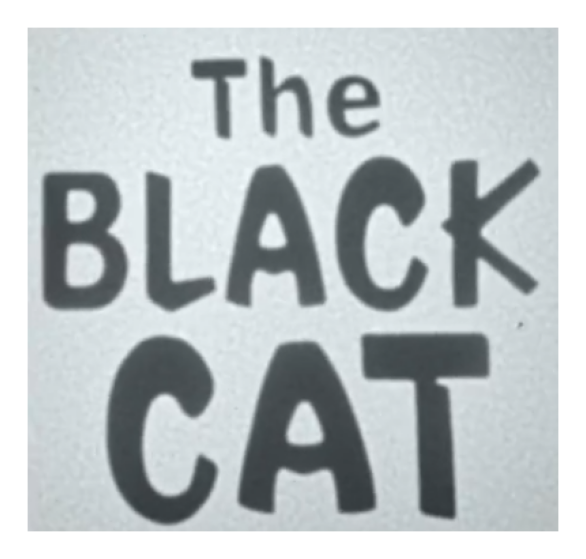

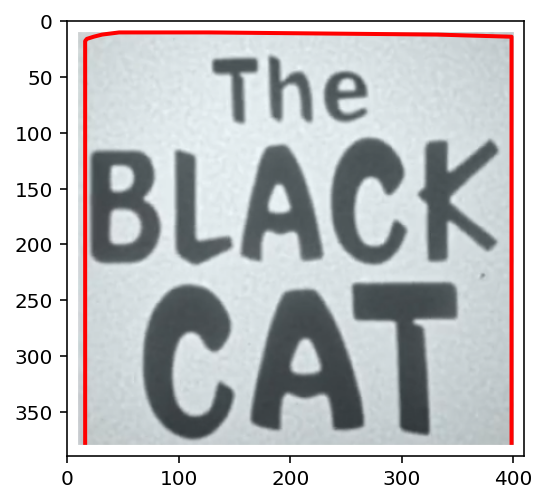

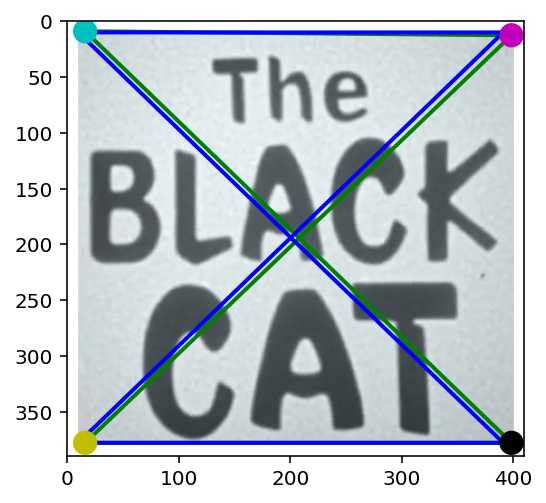

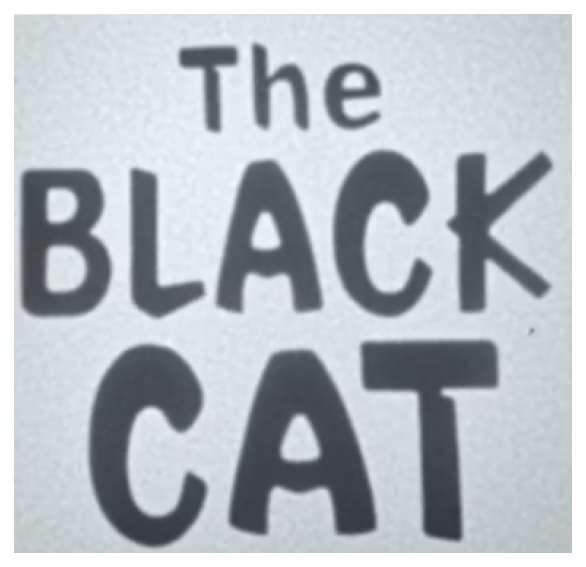

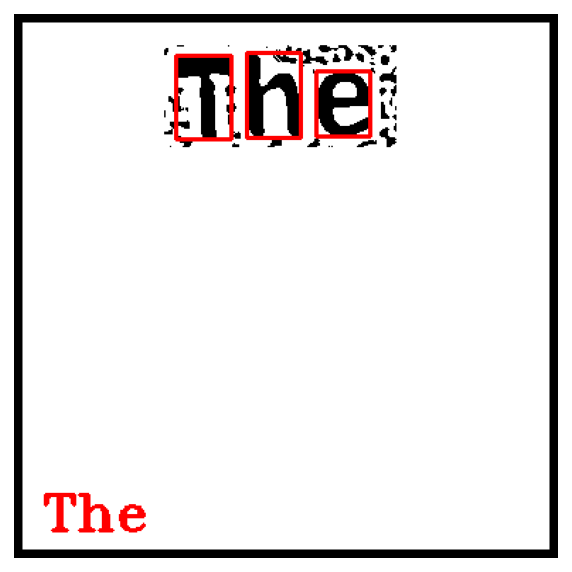

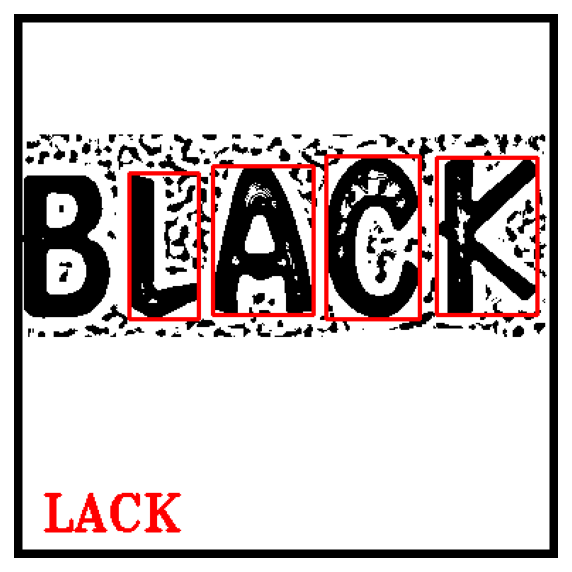

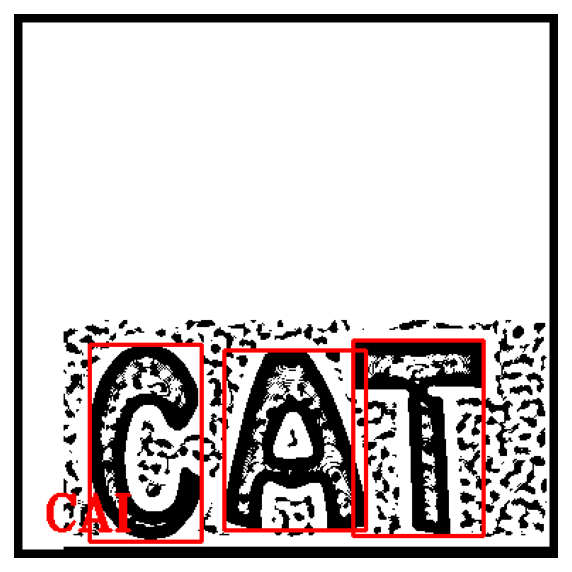

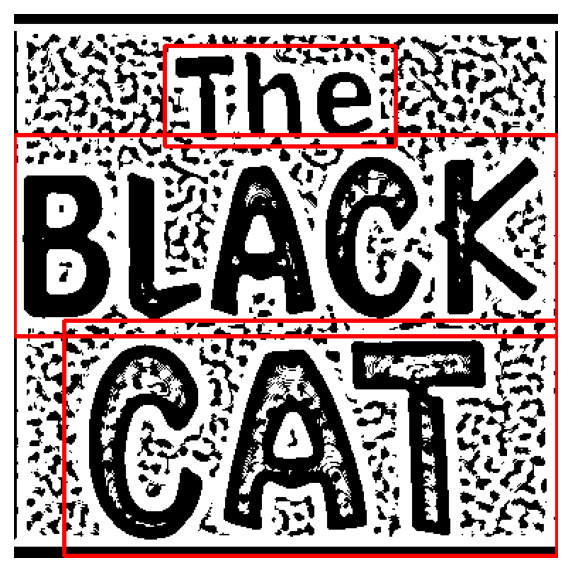

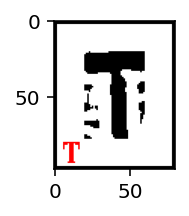

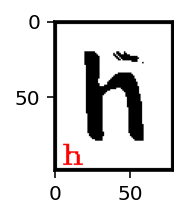

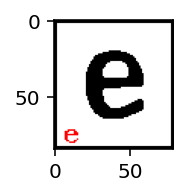

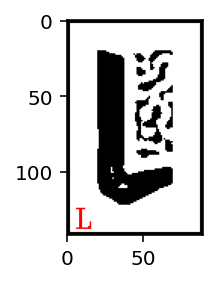

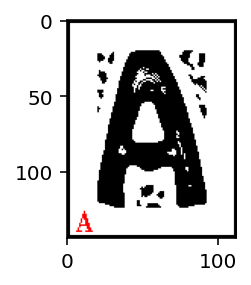

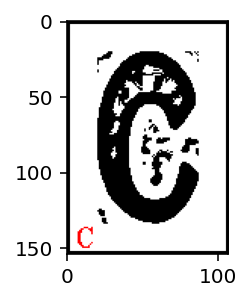

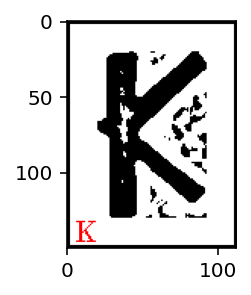

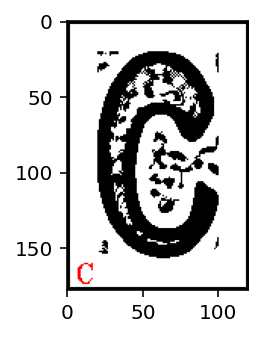

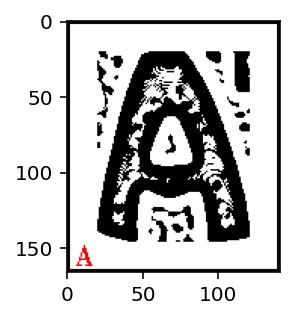

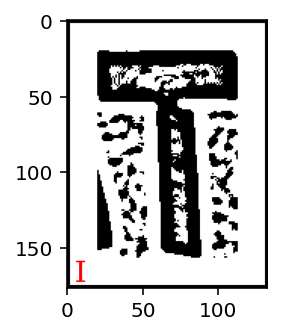

In [17]:
if __name__ == '__main__':
    ex.add_config('./configs/predict.yaml')
    ex.run(config_updates={
        'resume_dir': 'models/pretrained.pt', 
        'image_path': 'imgs/Screenshot 2020-11-18 at 12.58.10.png',
        'output_path': 'outputs/The_Black_Cat/',
#        'image_path': 'imgs/The_Black_Cat_sign_(40217238521).jpg',
#        'image_path': 'imgs/billboard.jpg',
#        'image_path': 'imgs/RHS_Hotel_Facade_v4.jpg',
    })